In [57]:
### Create map of plööp

### IMPORT DATA ###

# Import modules
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import geocode
import numpy as np
from pyproj import CRS
import requests
import geojson
import matplotlib.pyplot as plt
from shapely.ops import cascaded_union

## Read shape file containing the capital region as polygons into variable 'grid'
# File path
fp_grid = "data/pkseutu.shp"

# Read in data
grid = gpd.read_file(fp_grid)

# Check if crs is correct and set crs to ETRS89 / TM35FIN if the crs is not defined correctly
if (grid.crs != "epsg:3067"):    
    grid = grid.set_crs(epsg=3067)

# Check the data
print(grid.head())
print(grid.crs)

     GML_ID NATCODE     NAMEFIN      NAMESWE  LANDAREA  FRESHWAREA  SEAWAREA  \
0  27817426     091    Helsinki  Helsingfors    214.25        0.91    500.32   
1  27806267     049       Espoo         Esbo    312.32       17.91    197.80   
2  27817421     092      Vantaa        Vanda    238.37        1.98      0.00   
3  27806296     235  Kauniainen    Grankulla      5.89        0.11      0.00   

   TOTALAREA                                           geometry  
0     715.48  POLYGON ((399936.363 6684600.244, 399937.630 6...  
1     528.03  POLYGON ((379983.813 6681677.659, 379996.122 6...  
2     240.35  POLYGON ((399936.363 6684600.244, 399894.753 6...  
3       6.00  POLYGON ((374739.340 6677929.880, 374750.598 6...  
PROJCS["ETRS89_TM35FIN_E_N",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4258"]

In [58]:
## Read population grid data for 2018 into a variable `pop`. 

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
params = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Clean out unnecessary columns
pop = pop[["asukkaita", "geometry"]]

# Set crs to ETRS89 / GK25FIN and reproject to ETRS89 / TM35FIN if the crs is not defined correctly
if (pop.crs == None):    
    pop = pop.set_crs(epsg=3879)
if (pop.crs != "epsg:3067"):    
    pop = pop.to_crs(epsg=3067)

# Check the data
print(pop.head())
print(pop.crs)

   asukkaita                                           geometry
0        108  MULTIPOLYGON Z (((365582.138 6673970.899 0.000...
1        273  MULTIPOLYGON Z (((365839.544 6674213.167 0.000...
2        239  MULTIPOLYGON Z (((366127.234 6675454.796 0.000...
3        202  MULTIPOLYGON Z (((366119.663 6675204.958 0.000...
4        261  MULTIPOLYGON Z (((366112.092 6674955.121 0.000...
epsg:3067


In [71]:
## Read buffer polygons that describe 200 m accessibility via pedestrian and bicycle ways from metro and train stations 

# Specify the url for web feature service
url_buff = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format).
params_buff = dict(service='WFS',
              version='2.0.0',
              request='GetFeature',
              typeName='200m_verkostobufferi',
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url_buff, params=params_buff)

# Create GeoDataFrame from geojson
buff = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

# Clean out unnecessary columns
buff = buff[["asema", "geometry"]]

# Set crs to ETRS89 / GK25FIN and reproject to ETRS89 / TM35FIN if the crs is not defined correctly
if (buff.crs == None):    
    buff = buff.set_crs(epsg=3879)
if (buff.crs != "epsg:3067"):    
    buff = buff.to_crs(epsg=3067)
    
# Clip out stations that are located outside the capital region
#polygons = [grid.at[0,'geometry'], grid.at[1,'geometry'], grid.at[2,'geometry'], grid.at[3,'geometry']]
#boundary = gpd.GeoSeries(cascaded_union(polygons))
#boundary = boundary.set_crs(epsg=3067)
grid['constant'] = 0
boundary = grid.dissolve(by='constant')

clip_mask = buff.within(boundary.at[0,'geometry'])
buff = buff.loc[clip_mask]
#gpd.clip(buff, boundary)

# Check the data
print(buff.head())
print(len(buff))

           asema                                           geometry
0       Helsinki  MULTIPOLYGON (((385798.979 6672640.104, 385799...
1        Leinelä  MULTIPOLYGON (((391873.107 6688918.697, 391877...
3  Rautatientori  MULTIPOLYGON (((385796.886 6672409.483, 385813...
5      Koivuhovi  MULTIPOLYGON (((372679.134 6676880.670, 372701...
6       Siilitie  MULTIPOLYGON (((391655.312 6676062.512, 391670...
64


In [ ]:
### PROCESS DATA ###

# Create new column ''

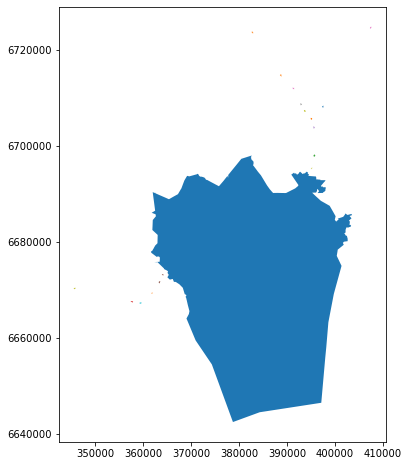

In [62]:
### PLOT DATA ###
# Create one subplot
fig, ax = plt.subplots(figsize=(12,8))

# Visualize 
pop.plot(ax=ax, column="asukkaita", cmap="YlOrBr", alpha=0.9)

buff.plot(ax=ax, column="asema")

boundary.plot(ax=ax)

# Disable scientific notation
ax.ticklabel_format(style='plain')
